# Učitavanje podataka

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("../data/train.csv")

train_df.shape
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Osnovna analiza i informacije

In [2]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Provjera nedostajućih vrijednosti

In [3]:
missing = train_df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

# Analiza ciljne varijable SalePrice

Text(0.5, 1.0, 'Distribucija SalePrice')

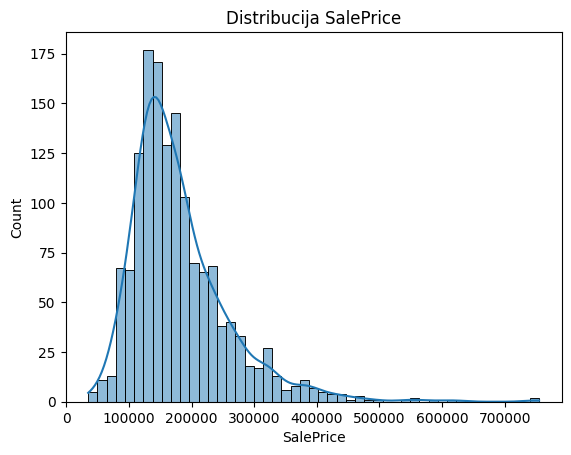

In [4]:
sns.histplot(train_df["SalePrice"], kde=True)
plt.title("Distribucija SalePrice")

# Provjera outliera

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

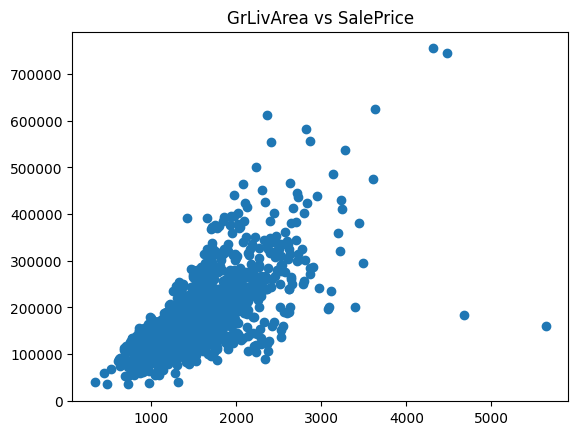

In [6]:
plt.scatter(train_df["GrLivArea"], train_df["SalePrice"])
plt.title("GrLivArea vs SalePrice")

# Analiza numeričkih i kategorijskih varijabli

In [9]:
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = train_df.select_dtypes(include=["object"]).columns

print("Broj numeričkih:", len(numeric_cols))
print("Broj kategorijskih:", len(categorical_cols))

train_df[categorical_cols].nunique().sort_values()

Broj numeričkih: 38
Broj kategorijskih: 43


Street            2
Alley             2
Utilities         2
CentralAir        2
MasVnrType        3
LandSlope         3
PavedDrive        3
GarageFinish      3
PoolQC            3
ExterQual         4
BsmtQual          4
BsmtExposure      4
BsmtCond          4
KitchenQual       4
LandContour       4
LotShape          4
Fence             4
MiscFeature       4
ExterCond         5
Electrical        5
HeatingQC         5
BldgType          5
MSZoning          5
LotConfig         5
GarageQual        5
GarageCond        5
FireplaceQu       5
Heating           6
BsmtFinType1      6
BsmtFinType2      6
RoofStyle         6
Foundation        6
GarageType        6
SaleCondition     6
Functional        7
HouseStyle        8
RoofMatl          8
Condition2        8
SaleType          9
Condition1        9
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64

# Korelacija s ciljnim atributom (SalePrice)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


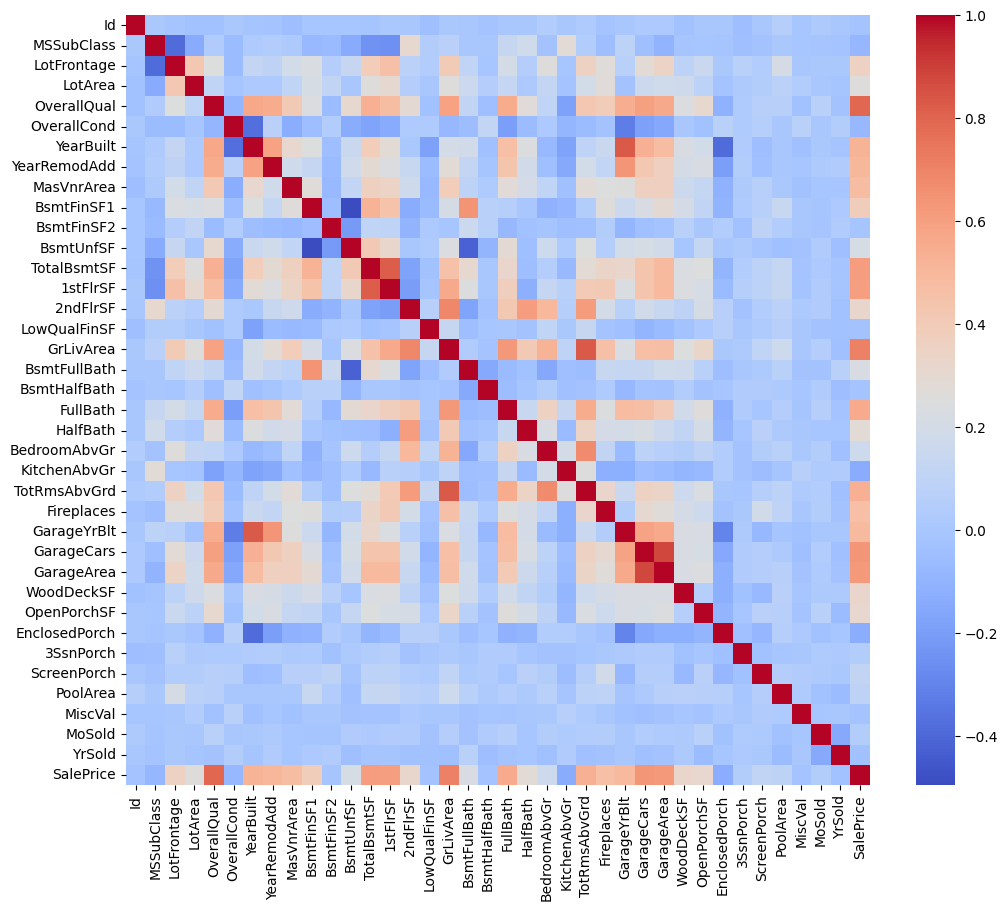

In [11]:
correlation = train_df[numeric_cols].corr()["SalePrice"].sort_values(ascending=False)
correlation.head(15)

# Vizualna korelacija (heatmap)
plt.figure(figsize=(12,10))
sns.heatmap(train_df[numeric_cols].corr(), cmap="coolwarm", annot=False)

correlation = train_df.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)
print(correlation.head(15))


# Unique vrijednosti za kategorijske kolone

In [8]:
train_df[categorical_cols].nunique().sort_values()

Street            2
Alley             2
Utilities         2
CentralAir        2
MasVnrType        3
LandSlope         3
PavedDrive        3
GarageFinish      3
PoolQC            3
ExterQual         4
BsmtQual          4
BsmtExposure      4
BsmtCond          4
KitchenQual       4
LandContour       4
LotShape          4
Fence             4
MiscFeature       4
ExterCond         5
Electrical        5
HeatingQC         5
BldgType          5
MSZoning          5
LotConfig         5
GarageQual        5
GarageCond        5
FireplaceQu       5
Heating           6
BsmtFinType1      6
BsmtFinType2      6
RoofStyle         6
Foundation        6
GarageType        6
SaleCondition     6
Functional        7
HouseStyle        8
RoofMatl          8
Condition2        8
SaleType          9
Condition1        9
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64